In [ ]:
import numpy as np
from tqdm import tqdm
import os

from videograph import VideoGraph
from utils.general import *
from utils.video_processing import *
from utils.chat_api import *
from prompts import *

from face_processing import process_faces
from voice_processing import process_voices
from memory_processing import (
    process_captions,
    generate_captions_and_thinkings_with_ids,
)

In [ ]:
def process_segment(video_graph, base64_video, base64_frames, base64_audio):

    id2voices = process_voices(video_graph, base64_audio, base64_video)
    print("Finish processing voices")

    print(f"processing {len(base64_frames)} frames...")

    id2faces = process_faces(video_graph, base64_frames)
    # print(id2faces.keys())
    print("Finish processing faces")

    episodic_captions, semantic_captions = generate_captions_and_thinkings_with_ids(
        base64_video,
        base64_frames,
        base64_audio,
        id2faces,
        id2voices,
    )

    process_captions(video_graph, episodic_captions, type="episodic")
    process_captions(video_graph, semantic_captions, type="semantic")

    print("Finish processing segment")


def streaming_process_video(
    video_graph, video_path, interval_seconds, fps, segment_limit=None
):
    """Process video segments at specified intervals with given fps.

    Args:
        video_graph (VideoGraph): Graph object to store video information
        video_path (str): Path to the video file or directory containing clips
        interval_seconds (float): Time interval between segments in seconds
        fps (float): Frames per second to extract from each segment

    Returns:
        None: Updates video_graph in place with processed segments
    """
    if os.path.isfile(video_path):
        # Process single video file
        video_info = get_video_info(video_path)
        print(video_info)

        # Process each interval
        count = 0
        for start_time in np.arange(0, video_info["duration"], interval_seconds):
            if start_time + interval_seconds > video_info["duration"]:
                break

            print("=" * 20)
            count += 1

            print(f"Loading {count}-th clip starting at {start_time} seconds...")
            base64_video, base64_frames, base64_audio = process_video_clip(
                video_path, start_time, interval_seconds, fps, audio_format="wav"
            )

            # check dtype
            # print(type(base64_video), type(base64_frames[0]), type(base64_audio))

            # Process frames for this interval
            if base64_frames:
                print(
                    f"Starting processing {count}-th clip starting at {start_time} seconds..."
                )
                process_segment(
                    video_graph,
                    base64_video,
                    base64_frames,
                    base64_audio,
                )

            if segment_limit is not None and count >= segment_limit:
                break

    elif os.path.isdir(video_path):
        # Process directory of numbered clips
        files = os.listdir(video_path)
        # Filter for video files and sort by numeric value in filename
        video_files = [
            f for f in files if any(f.endswith(ext) for ext in [".mp4", ".avi", ".mov"])
        ]
        video_files.sort(key=lambda x: int("".join(filter(str.isdigit, x))))

        for count, video_file in enumerate(video_files, 1):
            print("=" * 20)
            full_path = os.path.join(video_path, video_file)
            print(f"Processing clip {count}: {full_path}")

            base64_video, base64_frames, base64_audio = process_video_clip(
                full_path, 0, None, fps, audio_format="wav"
            )

            if base64_frames:
                process_segment(
                    video_graph,
                    base64_video,
                    base64_frames,
                    base64_audio,
                )

            if segment_limit is not None and count >= segment_limit:
                break

In [ ]:
# video_config = {
#     "video_path": "data/videos/clipped/5 Poor People vs 1 Secret Millionaire",
#     # "video_path": "/mnt/bn/videonasi18n/longlin.kylin/vlm-agent-benchmarking/data/videos/raw/720p/5 Poor People vs 1 Secret Millionaire.mp4",
#     "interval_seconds": 60,
#     "fps": 5,
#     "segment_limit": 5,
# }

# memory_config = {
#     "max_img_embeddings": 10,
#     "max_audio_embeddings": 20,
#     "img_matching_threshold": 0.3,
#     "audio_matching_threshold": 0.6,
#     "text_matching_threshold": 0.75,
# }

video_paths = [
        # "data/videos/clipped/n-B_kmAebbQ",
        # "data/videos/clipped/GTIjylkB-TI",
        # "data/videos/clipped/jvUX3ocBSCk",
        "data/videos/clipped/UPk8fzT4t8o"
]

for video_path in video_paths:
    video_config = {
        "video_path": video_path,
        "interval_seconds": 60,
        "fps": 5,
        "segment_limit": 5,
    }

    memory_config = {
        "max_img_embeddings": 10,
        "max_audio_embeddings": 20,
        "img_matching_threshold": 0.3,
        "audio_matching_threshold": 0.6,
        "text_matching_threshold": 0.75,
    }

    video_graph = VideoGraph(**memory_config)

    streaming_process_video(video_graph, **video_config)

    save_dir = "data/video_graphs"
    save_video_graph(video_graph, save_dir, (video_config, memory_config))

Loading video graph from data/video_graphs/5-Poor-People-vs-1-Secret-Millionaire_60_5_5_10_20_0.3_0.6_0.75.pkl
---------------------------------------------------------------------------------------------------- Image Node 4 ----------------------------------------------------------------------------------------------------


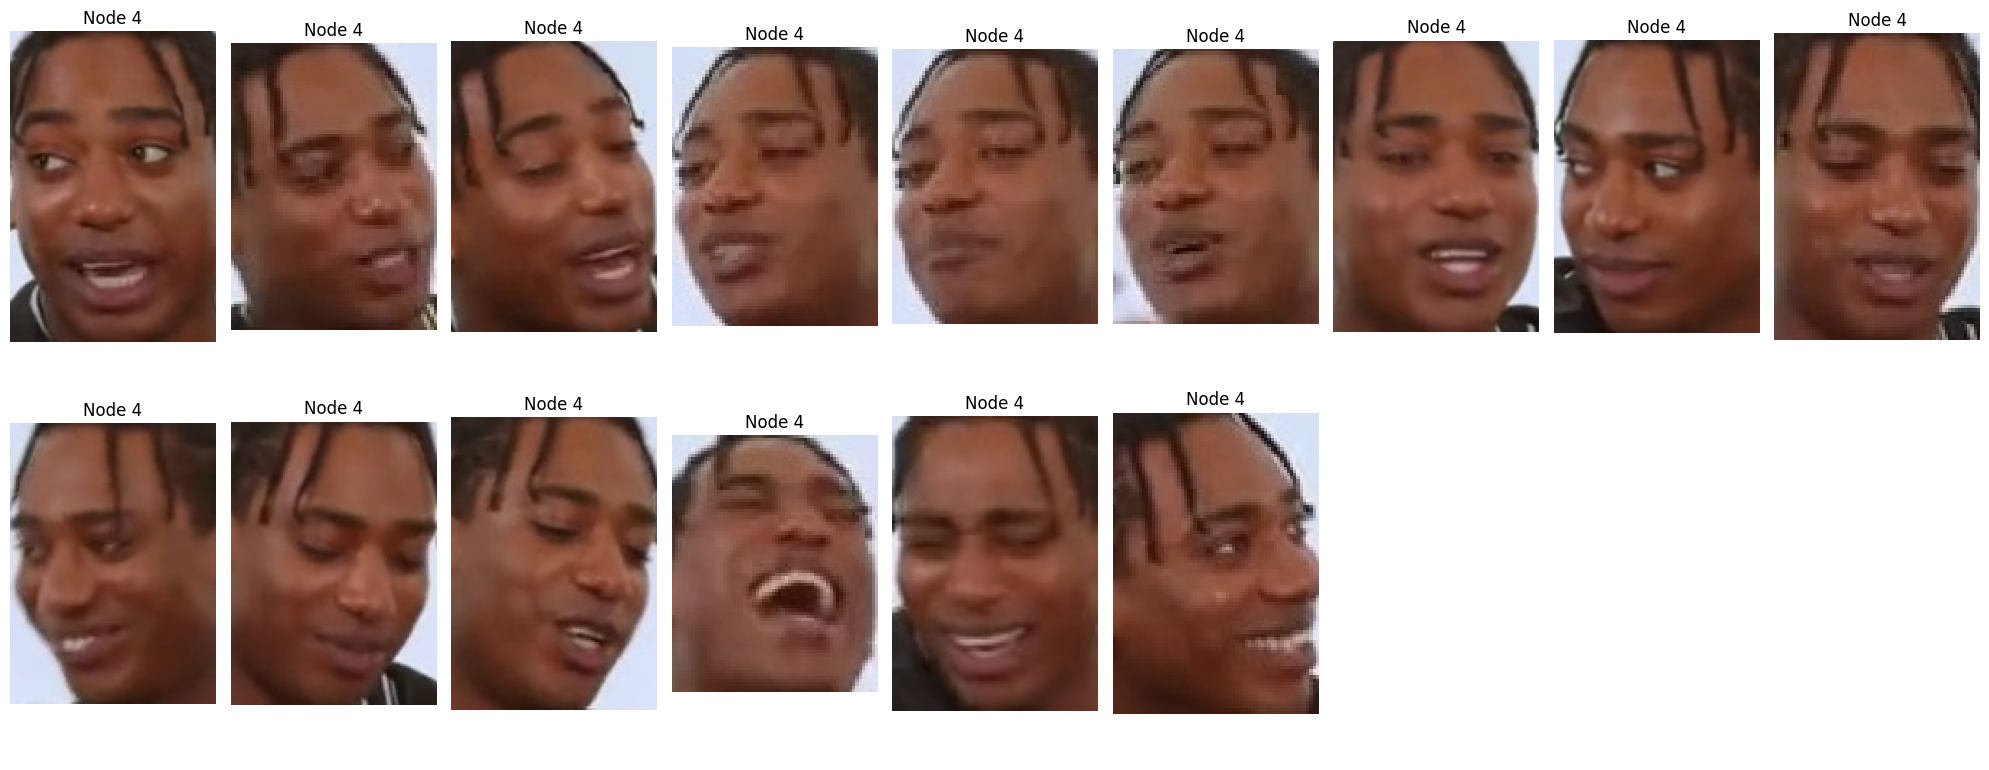

Connected Nodes: [129, 134, 143, 144, 22, 23, 24, 25, 26, 166, 43, 44, 45, 47, 51, 61, 62, 80, 84, 100, 101, 102, 106, 108, 109, 110, 124, 125]
Connected Nodes Contents: [['<char_6> points up and then points at <char_4>.'], ["<char_4> and <char_6> are amused by <speaker_112>'s family's involvement in the oil business."], ['<char_4> wears a black and white baseball jersey.'], ['<char_4> laughs and puts his head down on the table.'], ['<char_4> wears a white and blue baseball jersey.'], ['<char_4> raises his right hand.'], ['<char_4> points with his left hand at <char_11>.'], ["<speaker_0> (represented by <char_4>) says: 'We got Denny, Herm, Aaron, and JC and five people who say they're millionaire,'"], ["<speaker_0> (represented by <char_4>) says: 'but only one of them is. And the other four are lying. Let's just start by just appearances.'"], ["<char_5>, <char_6>, <char_4>, <char_53>, and <char_7> are likely reacting to the interviewees' answers on a show."], ['<speaker_2> (represented

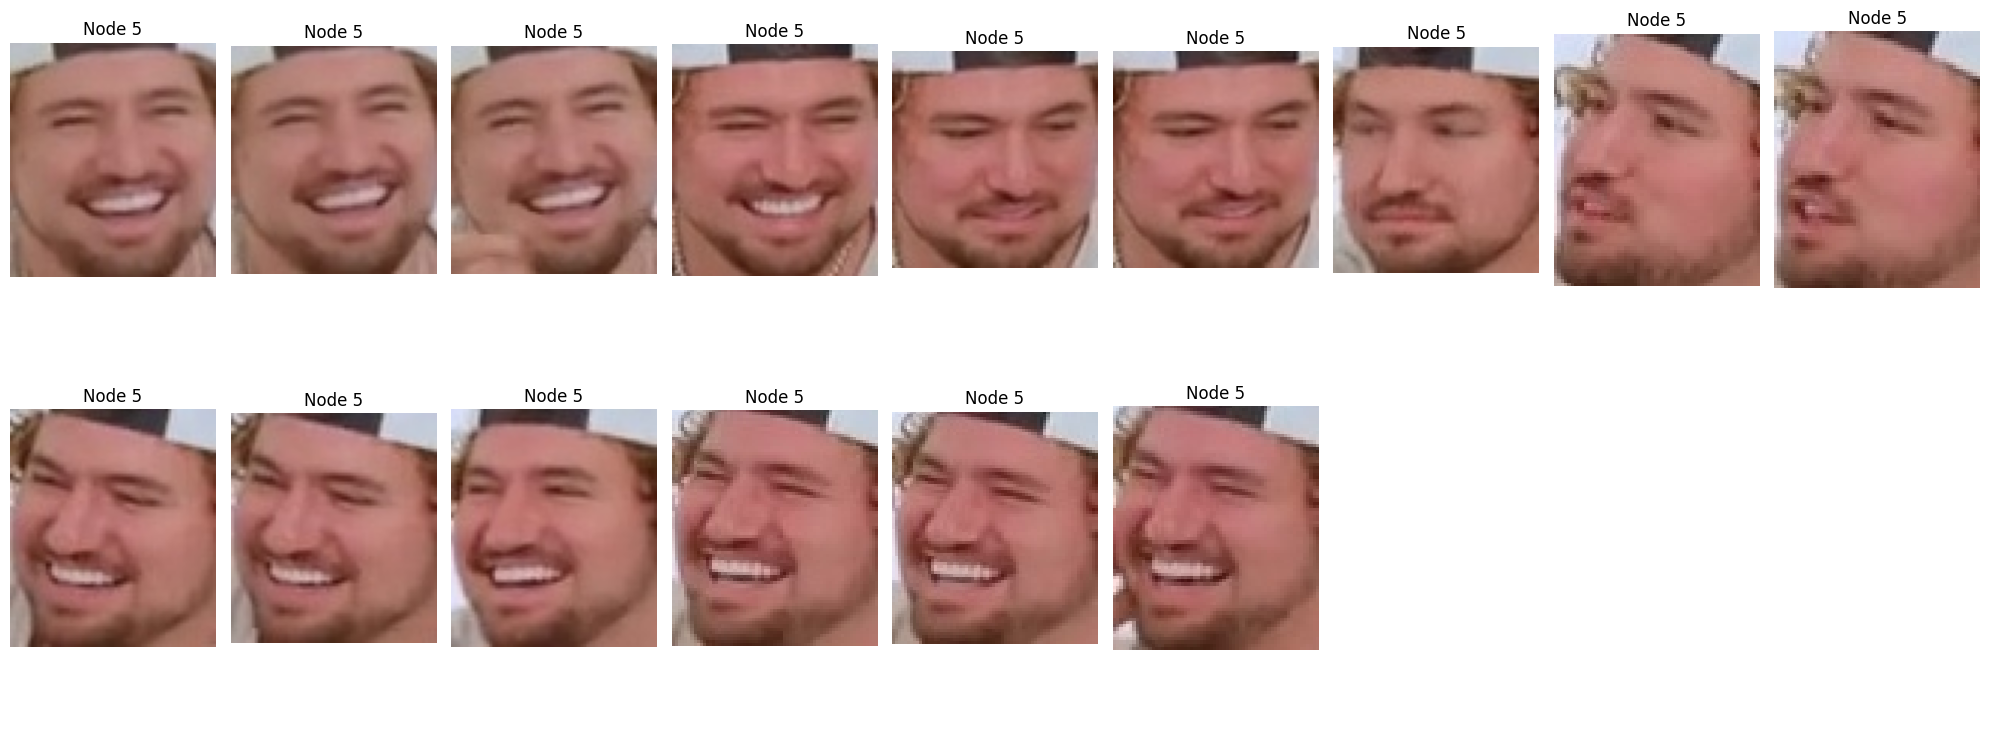

Connected Nodes: [65, 66, 166, 104, 136, 139, 140, 110, 16, 17, 18, 51, 49, 126, 127]
Connected Nodes Contents: [["<char_5> wears a beige t-shirt with the word 'Rude' printed on it."], ['<char_5> has tattoos on his left arm.'], ["<char_5>, <char_6>, <char_4>, <char_53>, and <char_7> are likely reacting to the interviewees' answers on a show."], ['<char_5> wears a light beige t-shirt and a white baseball cap.'], ['<char_5> and <char_53> appear entertained by the conversation.'], ['<char_5> wears a white t-shirt and a baseball cap.'], ['<char_5> laughs and covers his ears.'], ['<char_5> and <char_6> appear to be acquaintances or colleagues of <char_4>, given their proximity and interaction.'], ['<char_5> wears a white t-shirt with a graphic and dark pants.'], ['<char_5> sits at the table.'], ['<char_5> points at <char_11>.'], ['<char_4>, <char_5>, <char_6>, and <char_7> are analyzing and judging the other individuals based on their appearance.'], ['<char_5> is likely wealthy, as the vide

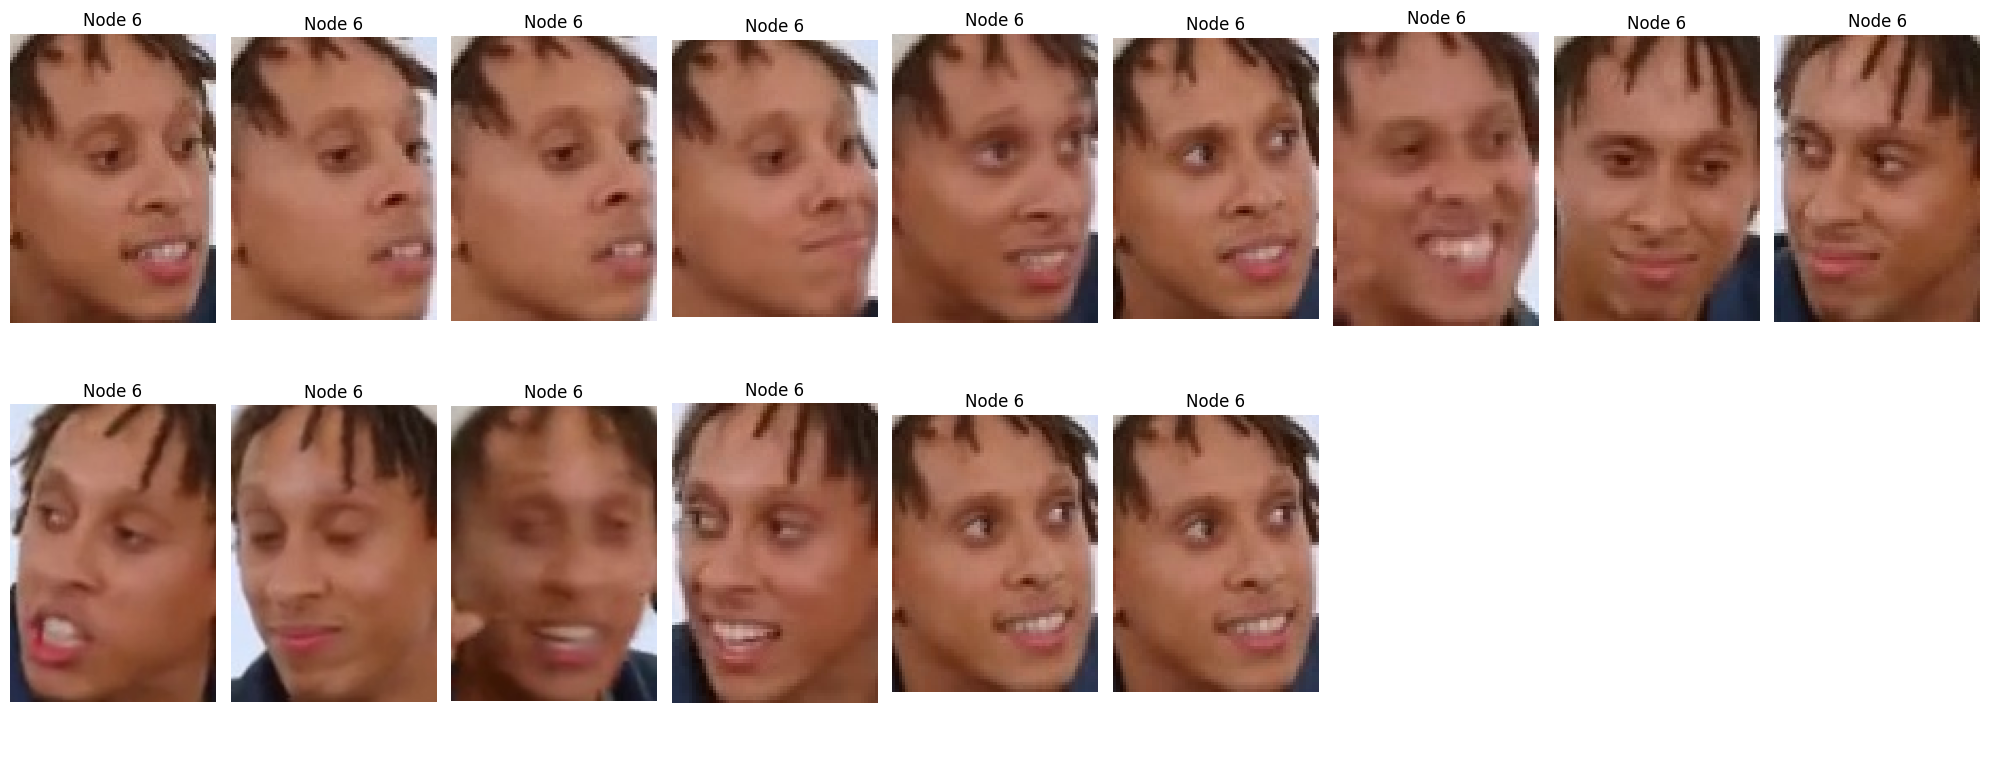

Connected Nodes: [64, 128, 129, 134, 103, 166, 141, 110, 142, 51, 19, 20, 21, 63]
Connected Nodes Contents: [['<char_6> holds a plastic water bottle.'], ['<char_6> wears a dark blue button-down shirt and a tan beanie.'], ['<char_6> points up and then points at <char_4>.'], ["<char_4> and <char_6> are amused by <speaker_112>'s family's involvement in the oil business."], ['<char_6> wears a blue denim jacket, a white beanie, and dark blue jeans.'], ["<char_5>, <char_6>, <char_4>, <char_53>, and <char_7> are likely reacting to the interviewees' answers on a show."], ['<char_6> wears a blue jacket and a white beanie.'], ['<char_5> and <char_6> appear to be acquaintances or colleagues of <char_4>, given their proximity and interaction.'], ['<char_6> holds a bottle of water.'], ['<char_4>, <char_5>, <char_6>, and <char_7> are analyzing and judging the other individuals based on their appearance.'], ['<char_6> wears a blue denim jacket and a white knit cap.'], ['<char_6> sits at a table.'], [

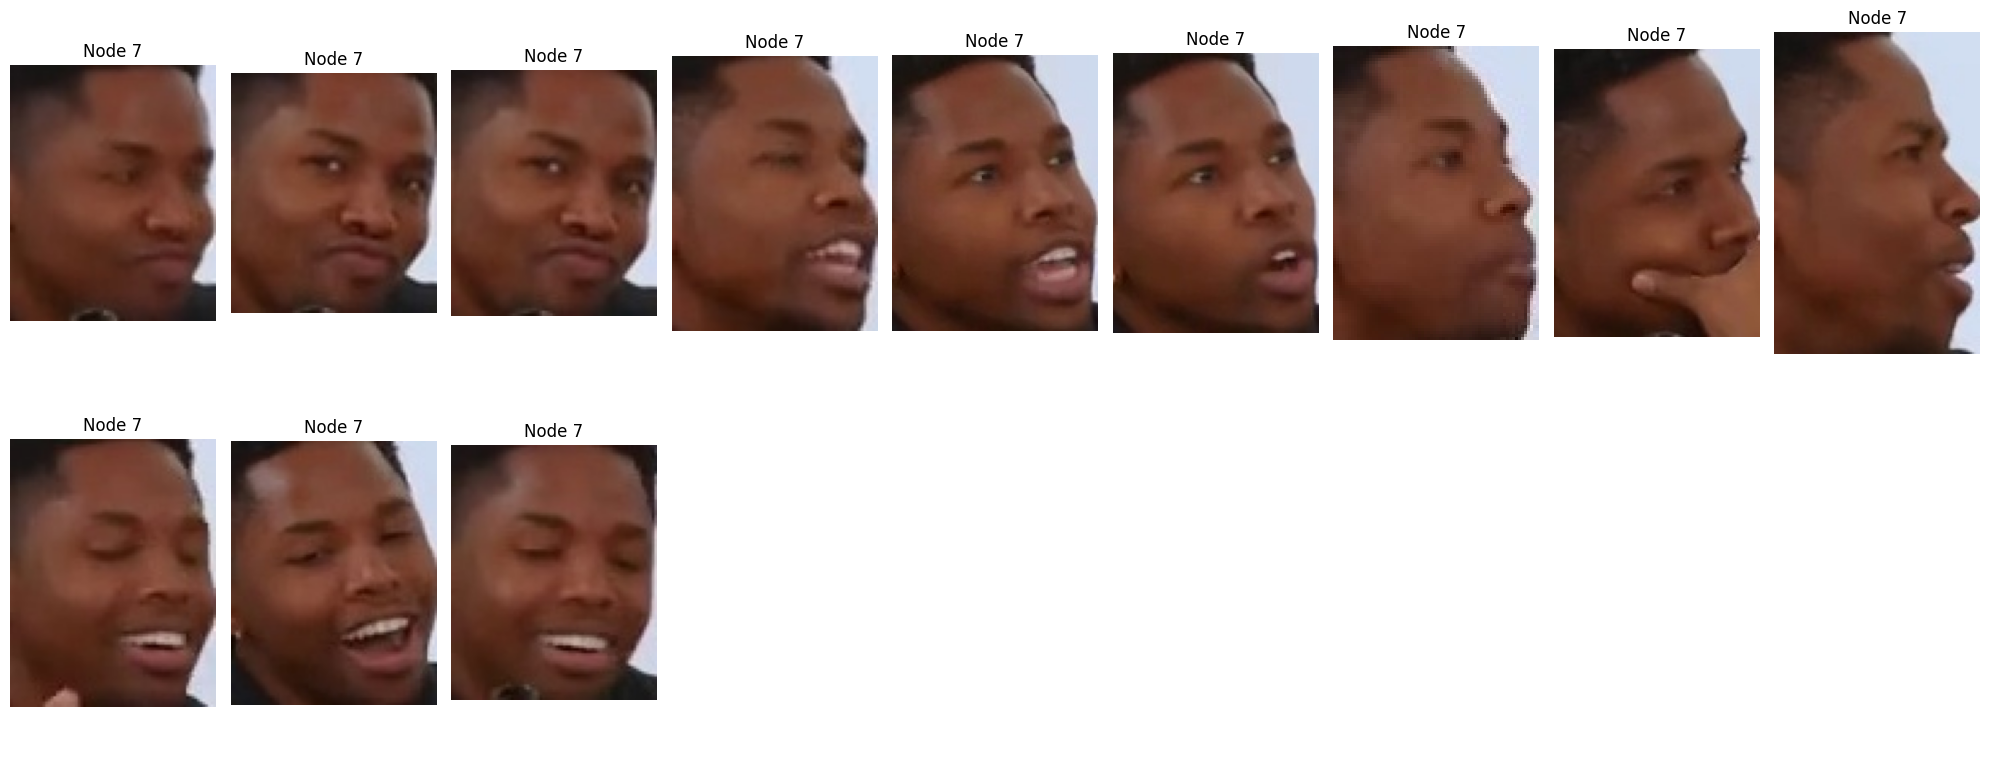

Connected Nodes: [166, 135, 105, 106, 13, 46, 14, 15, 81, 82, 51, 109, 147, 148, 55, 56, 122, 123]
Connected Nodes Contents: [["<char_5>, <char_6>, <char_4>, <char_53>, and <char_7> are likely reacting to the interviewees' answers on a show."], ["<char_7> seems surprised by <speaker_112>'s statement."], ['<char_7> wears a blue Drexel hoodie and glasses.'], ["<char_7> laughs at <char_4>'s antics."], ['<char_7> wears a black hoodie.'], ['<char_7> is <speaker_0>.'], ['<char_7> sits at a table.'], ['<char_7> points with his right hand at <char_11>.'], ["<speaker_2> (represented by <char_7>) says: 'We're gazing over number two, our beautiful lady here.'"], ['<char_7> is <speaker_3>.'], ['<char_4>, <char_5>, <char_6>, and <char_7> are analyzing and judging the other individuals based on their appearance.'], ['<char_7> is likely a friend or colleague of <char_4>, as they are seated next to each other and share a laugh.'], ['<char_7> wears a black sweatshirt with white text on it.'], ['<char_7

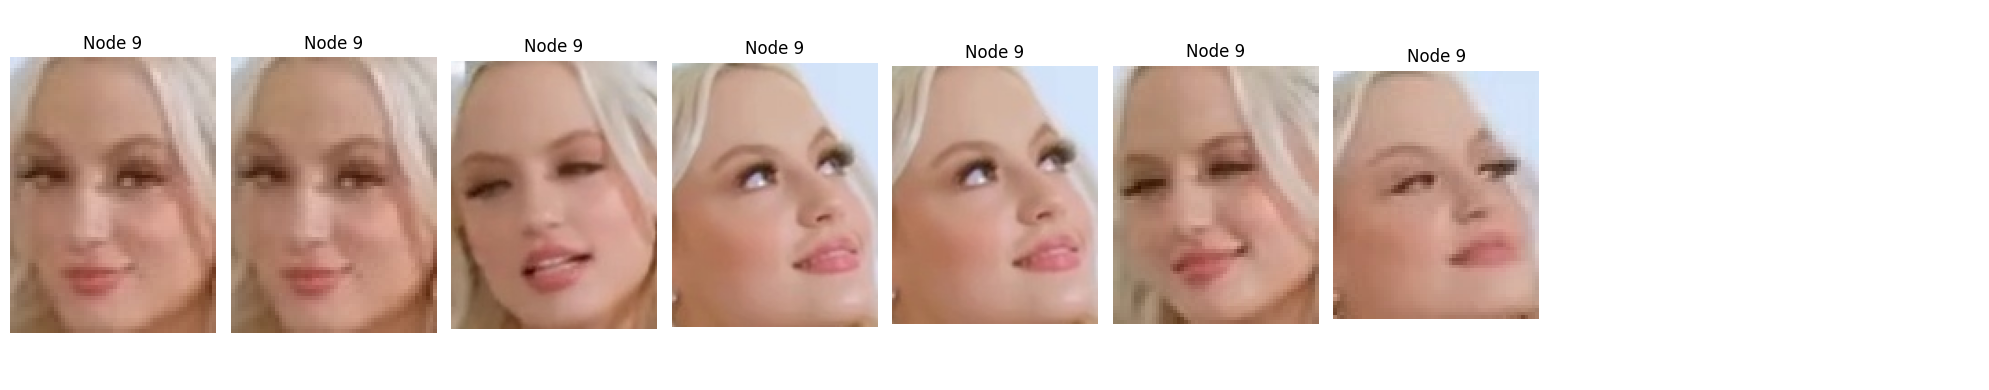

Connected Nodes: [32, 33, 35, 132, 74, 75, 117, 118, 119, 153, 154, 123, 31]
Connected Nodes Contents: [['<char_9> stands next to <char_11>.'], ['<char_9> places her hand over her mouth, as if stifling laughter.'], ['<char_10> stands next to <char_9>.'], ['<char_9> is <speaker_112>.'], ['<char_9> wears an orange baseball cap, a camouflage jacket, a striped collared shirt, and khaki pants.'], ['<char_9> stands with his hands in his pockets.'], ['<char_11> smiles at <char_9>.'], ['<char_9> wears a purple velvet blazer over a sparkly crop top.'], ['<char_9> states, "Uh, I\'m Tori K. and, uh, my family works in the oil business."'], ['<char_9> wears a purple jacket and black pants.'], ['<char_9> stands with her hands clasped in front of her.'], ["<char_7> puts his hand over his mouth in reaction to <char_9>'s statement."], ['<char_9> wears a purple blazer over a black top and black pants.']]
---------------------------------------------------------------------------------------------------

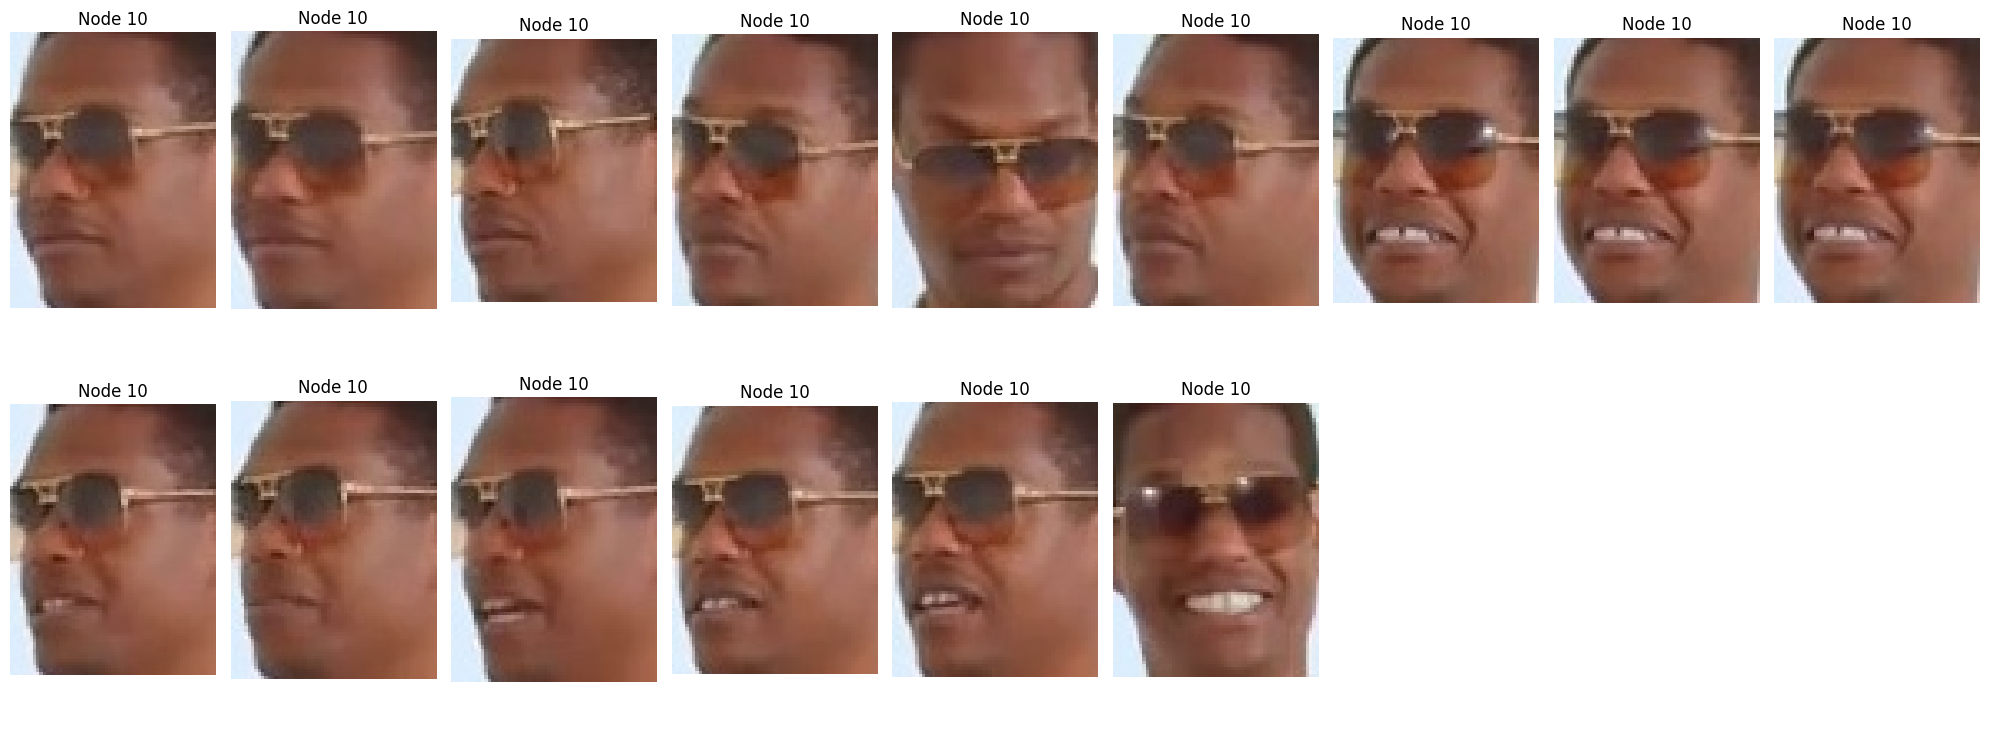

Connected Nodes: [133, 149, 150, 156, 157, 161, 34, 35, 36, 38, 50, 69, 70, 71, 78, 85, 93, 94, 120, 121]
Connected Nodes Contents: [['<char_10> is <speaker_115>.'], ['<char_10> wears a white long-sleeved shirt and gold sunglasses.'], ["<char_10> says: 'Uh, I'm a creative.'"], ['<char_12> looks at <char_10>.'], ["<char_10> says: 'Yeah, yeah, it's uh, my OnlyFans handle, so.'"], ['<char_10> is <speaker_115>.'], ['<char_10> wears sunglasses, a white collared shirt, and khaki pants.'], ['<char_10> stands next to <char_9>.'], ['<char_10> laughs.'], ['<char_12> stands next to <char_10>.'], ['<char_11>, <char_10>, <char_12>, and <char_8> are perceived as potentially not wealthy due to their clothing or lack of stylish accessories.'], ['<char_10> is wearing a white, long-sleeved, button-up shirt and khaki pants.'], ['<char_10> wears sunglasses.'], ['<char_10> stands with his hands clasped in front of him.'], ["<speaker_2> (represented by <char_10>) says: 'millionaires don't dress up.'"], ['<c

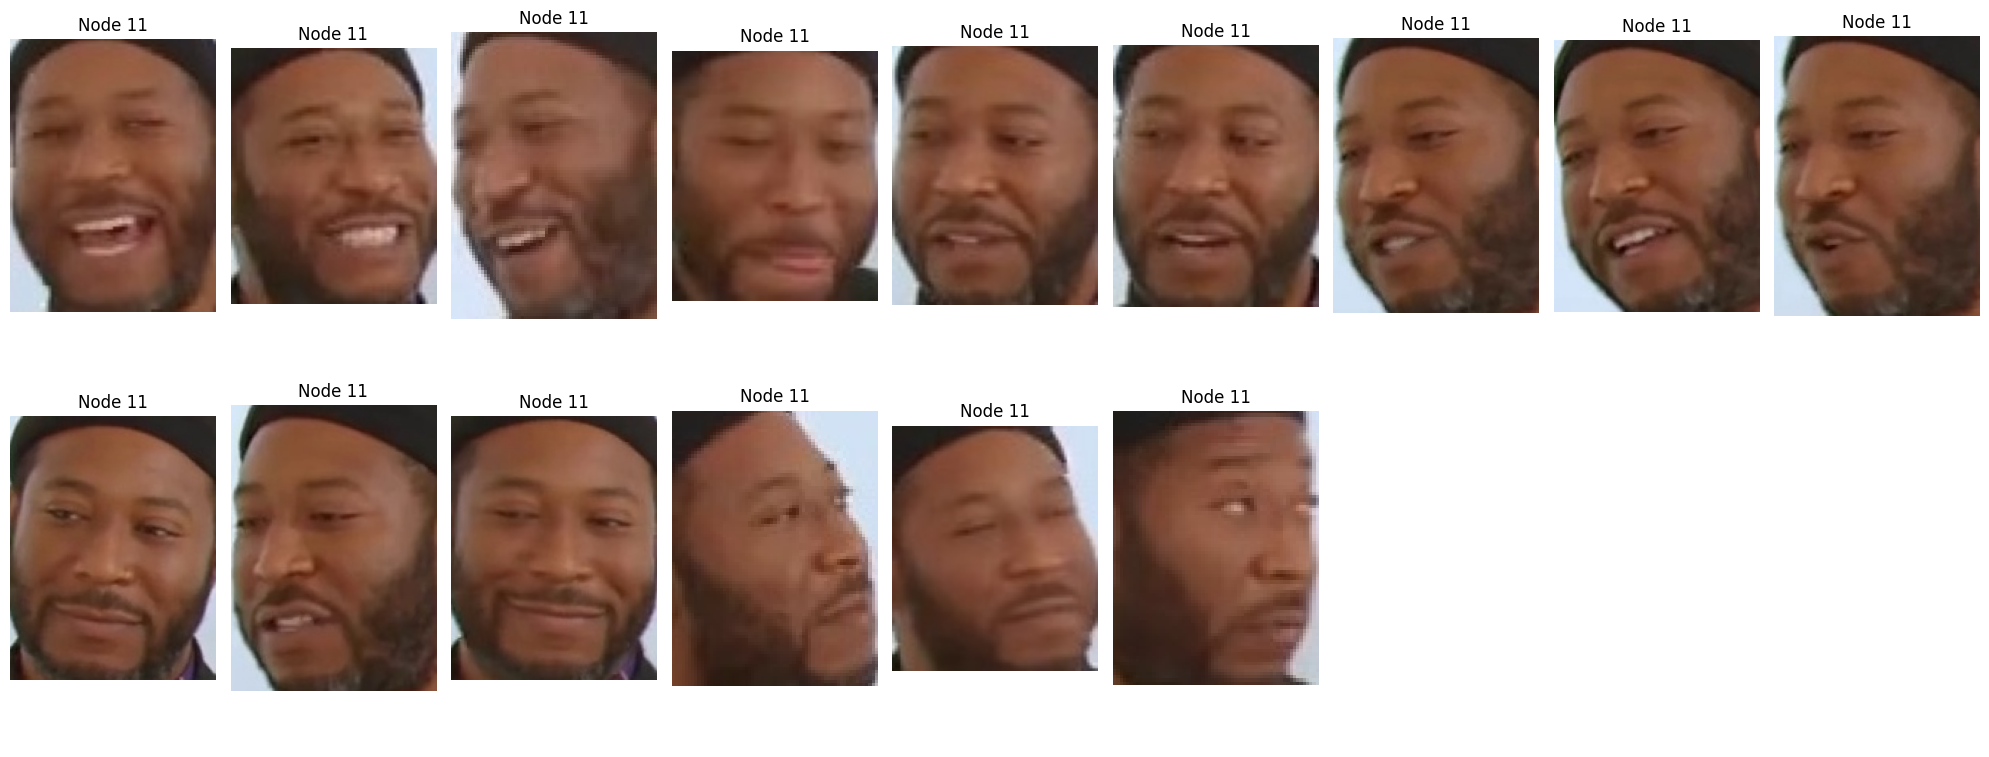

Connected Nodes: [15, 18, 151, 24, 152, 27, 28, 29, 30, 32, 48, 50, 67, 68, 96, 97, 98, 107, 116, 117]
Connected Nodes Contents: [['<char_7> points with his right hand at <char_11>.'], ['<char_5> points at <char_11>.'], ['<char_11> wears a black jacket and jeans.'], ['<char_4> points with his left hand at <char_11>.'], ['<char_11> covers his face with his hand.'], ['<char_11> wears a black jacket with a plaid shirt underneath and blue jeans.'], ['<char_11> stands with hands clasped in front of him.'], ['<char_11> gestures with his hands.'], ["<speaker_1> (represented by <char_11>) says: 'Got bills. Got bills.'"], ['<char_9> stands next to <char_11>.'], ['<char_11> is <speaker_1>.'], ['<char_11>, <char_10>, <char_12>, and <char_8> are perceived as potentially not wealthy due to their clothing or lack of stylish accessories.'], ['<char_11> is wearing a black bomber jacket and light wash jeans.'], ['<char_11> stands with his hands clasped in front of him.'], ['<char_11> wears a black jack

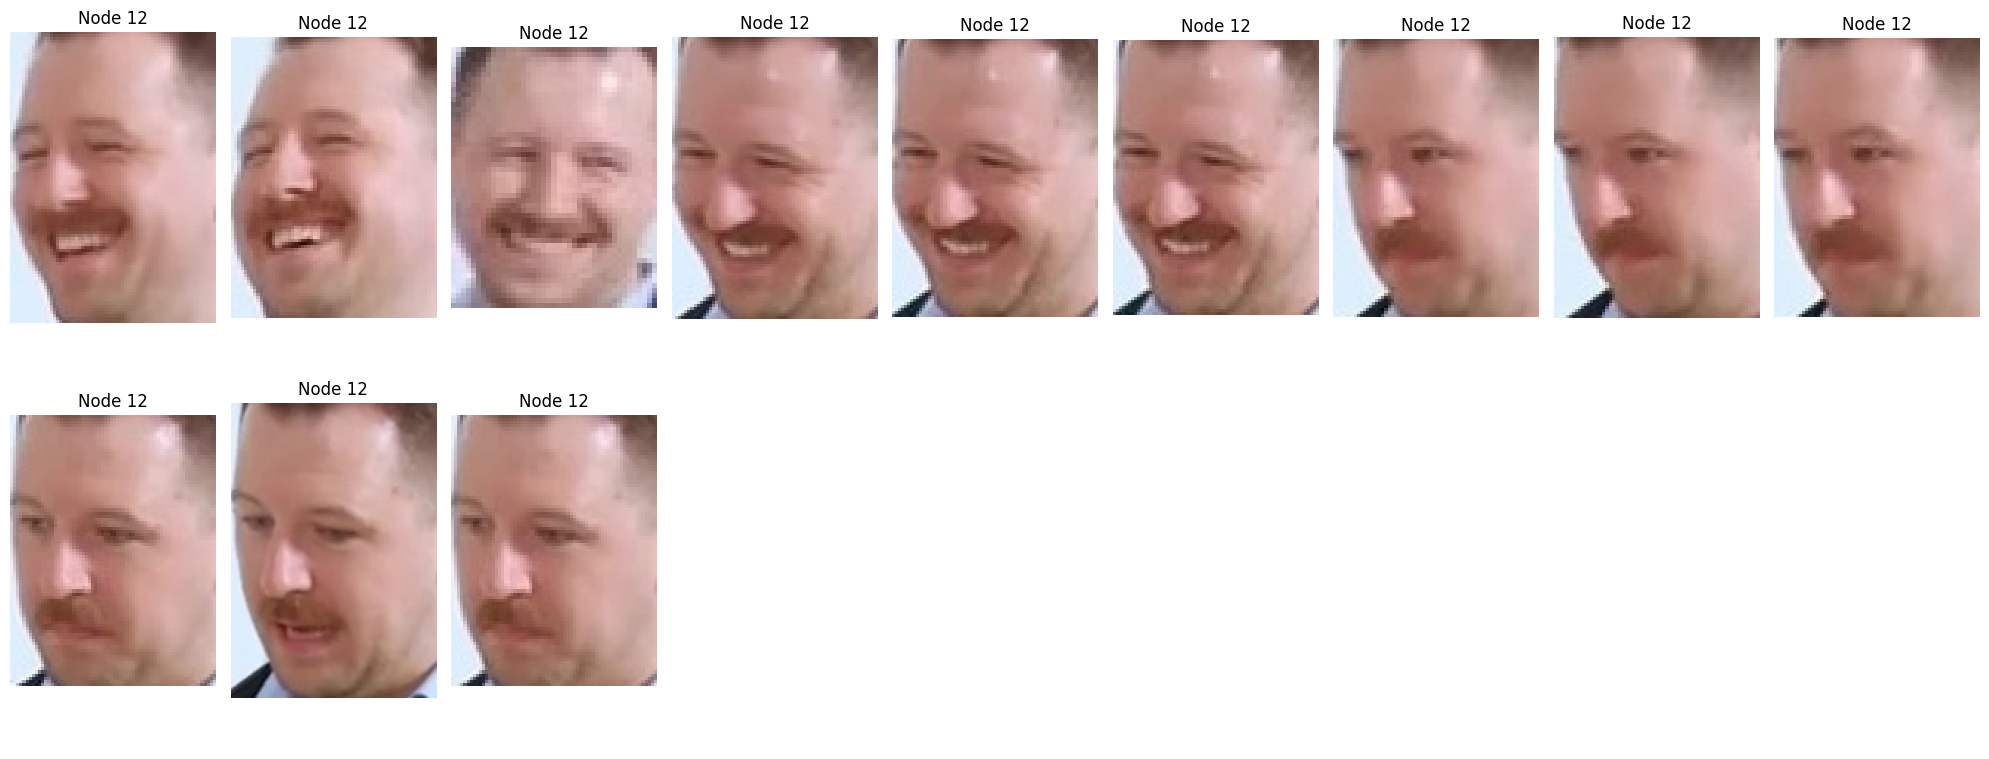

Connected Nodes: [160, 162, 37, 38, 39, 72, 73, 50, 155, 156, 95]
Connected Nodes Contents: [["<char_12> says: 'Uh, my name is Stuart Thompson, and I am a professor.'"], ['<char_12> is <speaker_138>.'], ['<char_12> wears a navy blue jacket over a light blue shirt and gray pants.'], ['<char_12> stands next to <char_10>.'], ['<char_12> laughs.'], ['<char_12> wears a navy blue jacket, a light blue collared shirt, and grey pants.'], ['<char_12> smiles and looks at the others in the room.'], ['<char_11>, <char_10>, <char_12>, and <char_8> are perceived as potentially not wealthy due to their clothing or lack of stylish accessories.'], ['<char_12> wears a navy button-down shirt and gray pants.'], ['<char_12> looks at <char_10>.'], ['<char_12> wears a dark blue jacket, a light blue and white striped shirt, and dark gray pants.']]
---------------------------------------------------------------------------------------------------- Image Node 52 --------------------------------------------------

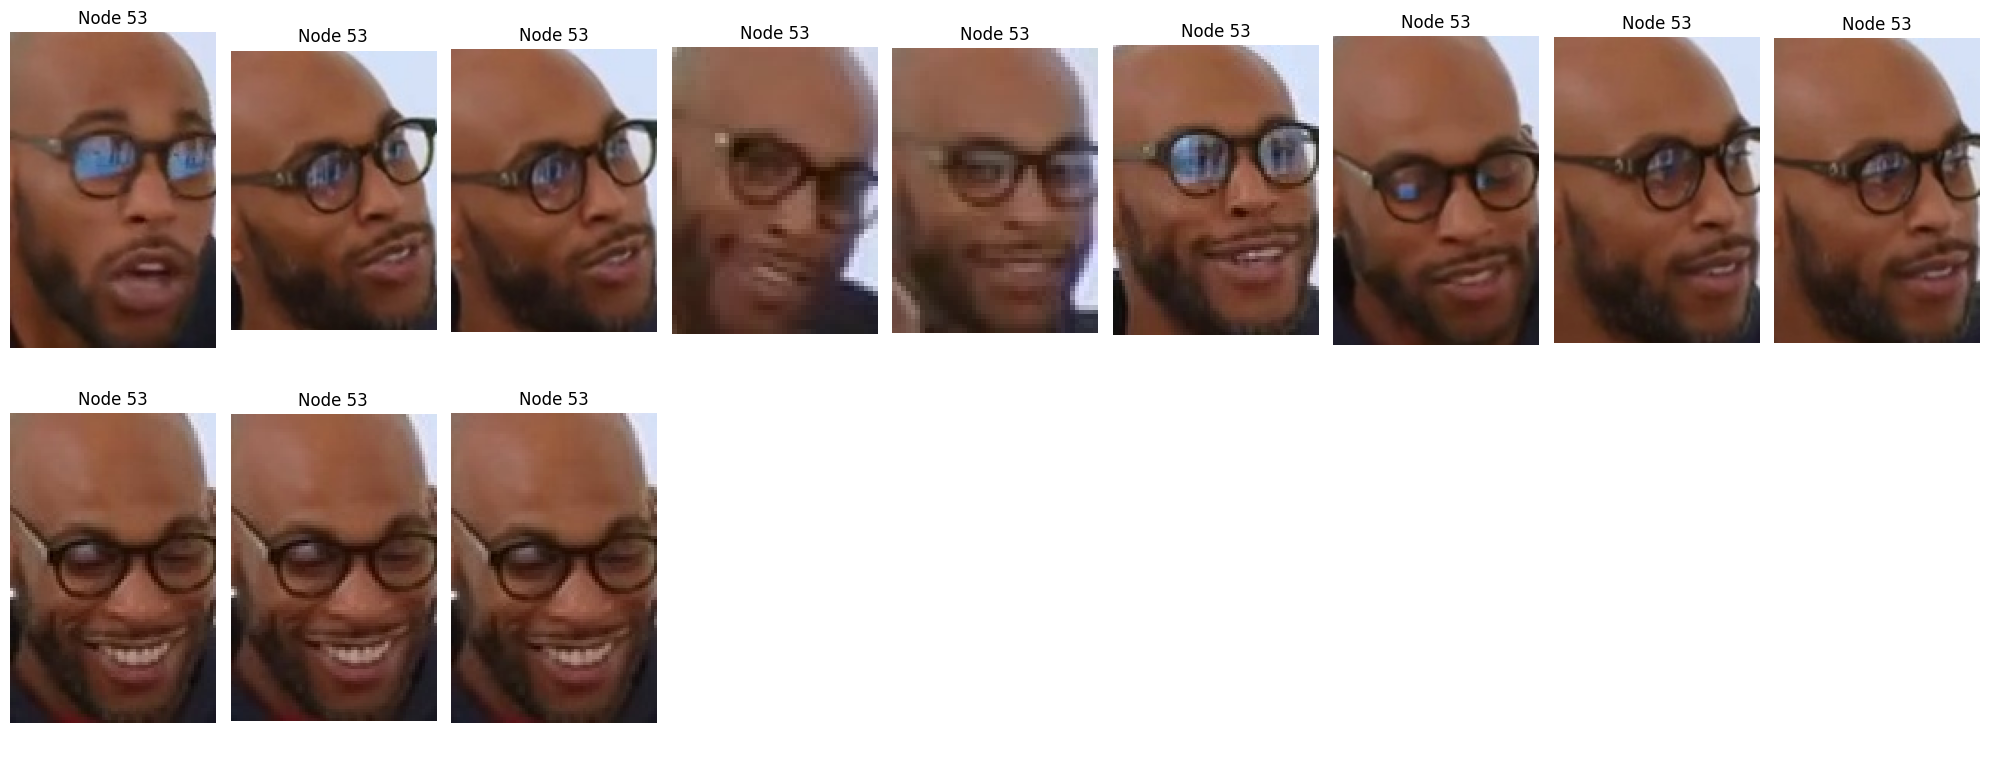

Connected Nodes: [130, 99, 131, 166, 136, 79, 111, 145, 146, 83, 57, 58, 59, 60]
Connected Nodes Contents: [['<char_53> wears a blue Drexel University hoodie.'], ['<char_53> wears a black hoodie with white lettering on the chest.'], ['<char_53> crosses his arms and smiles.'], ["<char_5>, <char_6>, <char_4>, <char_53>, and <char_7> are likely reacting to the interviewees' answers on a show."], ['<char_5> and <char_53> appear entertained by the conversation.'], ["<speaker_3> (represented by <char_53>) says: 'You look like you're pretending that you have money, but you work at Gelsons.'"], ['<char_53> may be less engaged in the conversation, possibly due to shyness or a more reserved personality.'], ['<char_53> wears a navy blue Drexel sweatshirt.'], ['<char_53> has his arms crossed.'], ['<char_53> is <speaker_3>.'], ['<char_53> wears a navy blue Drexel University hoodie.'], ['<char_53> wears glasses and has a short beard.'], ['<char_53> sits at a table with arms crossed.'], ["<speaker_3>

In [2]:
video_config = {
    "video_path": "data/videos/clipped/5 Poor People vs 1 Secret Millionaire",
    # "video_path": "/mnt/bn/videonasi18n/longlin.kylin/vlm-agent-benchmarking/data/videos/raw/720p/5 Poor People vs 1 Secret Millionaire.mp4",
    "interval_seconds": 60,
    "fps": 5,
    "segment_limit": 5,
}

memory_config = {
    "max_img_embeddings": 10,
    "max_audio_embeddings": 20,
    "img_matching_threshold": 0.3,
    "audio_matching_threshold": 0.6,
    "text_matching_threshold": 0.75,
}

save_dir = "data/video_graphs"

video_graph = load_video_graph(save_dir, (video_config, memory_config))
video_graph.visualize()

In [ ]:
# from retrieve import retrieve_from_videograph
from videograph import VideoGraph
from utils.chat_api import (
    generate_messages,
    get_response_with_retry,
    parallel_get_embedding,
)
from utils.general import validate_and_fix_python_list
from prompts import prompt_memory_retrieval

MAX_RETRIES = 3


def generate_queries(question, existing_knowledge=None, query_num=1):
    input = [
        {
            "type": "text",
            "content": prompt_memory_retrieval.format(
                question=question,
                query_num=query_num,
                existing_knowledge=existing_knowledge,
            ),
        }
    ]
    messages = generate_messages(input)
    model = "gpt-4o-2024-11-20"
    queries = None
    for i in range(MAX_RETRIES):
        print(f"Generating queries {i} times")
        queries = get_response_with_retry(model, messages)[0]
        queries = validate_and_fix_python_list(queries)
        if queries is not None:
            break
    if queries is None:
        raise Exception("Failed to generate queries")
    return queries


def retrieve_from_videograph(videograph, question, topk=3):
    queries = generate_queries(question)
    print(f"Queries: {queries}")

    model = "text-embedding-3-large"
    query_embeddings = parallel_get_embedding(model, queries)[0]

    related_nodes = []

    for query_embedding in query_embeddings:
        nodes = videograph.search_text_nodes(query_embedding)
        related_nodes.extend(nodes)

    related_nodes = list(set(related_nodes))
    return related_nodes


question = "Denny"
retrieved_nodes = retrieve_from_videograph(video_graph, question)
print(retrieved_nodes)